## 导入必要的库

In [1]:
# 系统库
import os 
import itertools 
from PIL import Image
# 数据处理库
import cv2 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,classification_report 
# 深度学习库 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam ,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras import regularizers
import warnings 
warnings.filterwarnings('ignore')


## 数据处理

In [2]:
train_data_dir = 'brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data 

,filepaths,labels
0,brain-tumor-mri-dataset/Training\glioma\Tr-glT...,glioma
1,brain-tumor-mri-dataset/Training\glioma\Tr-glT...,glioma
2,brain-tumor-mri-dataset/Training\glioma\Tr-glT...,glioma
3,brain-tumor-mri-dataset/Training\glioma\Tr-glT...,glioma
4,brain-tumor-mri-dataset/Training\glioma\Tr-glT...,glioma
...,...,...
5707,brain-tumor-mri-dataset/Training\pituitary\Tr-...,pituitary
5708,brain-tumor-mri-dataset/Training\pituitary\Tr-...,pituitary
5709,brain-tumor-mri-dataset/Training\pituitary\Tr-...,pituitary
5710,brain-tumor-mri-dataset/Training\pituitary\Tr-...,pituitary


In [3]:
test_data_dir = 'brain-tumor-mri-dataset/Testing' 
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath) 
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt 

,filepaths,labels
0,brain-tumor-mri-dataset/Testing\glioma\Te-glTr...,glioma
1,brain-tumor-mri-dataset/Testing\glioma\Te-glTr...,glioma
2,brain-tumor-mri-dataset/Testing\glioma\Te-glTr...,glioma
3,brain-tumor-mri-dataset/Testing\glioma\Te-glTr...,glioma
4,brain-tumor-mri-dataset/Testing\glioma\Te-glTr...,glioma
...,...,...
1306,brain-tumor-mri-dataset/Testing\pituitary\Te-p...,pituitary
1307,brain-tumor-mri-dataset/Testing\pituitary\Te-p...,pituitary
1308,brain-tumor-mri-dataset/Testing\pituitary\Te-p...,pituitary
1309,brain-tumor-mri-dataset/Testing\pituitary\Te-p...,pituitary


## 划分数据集为验证集和测试集

In [4]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)  # 按照1：1的比例划分验证集和测试集

## 创建图片数据生成器

In [5]:
batch_size=16
img_size = (224,224)
channels = 3 
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


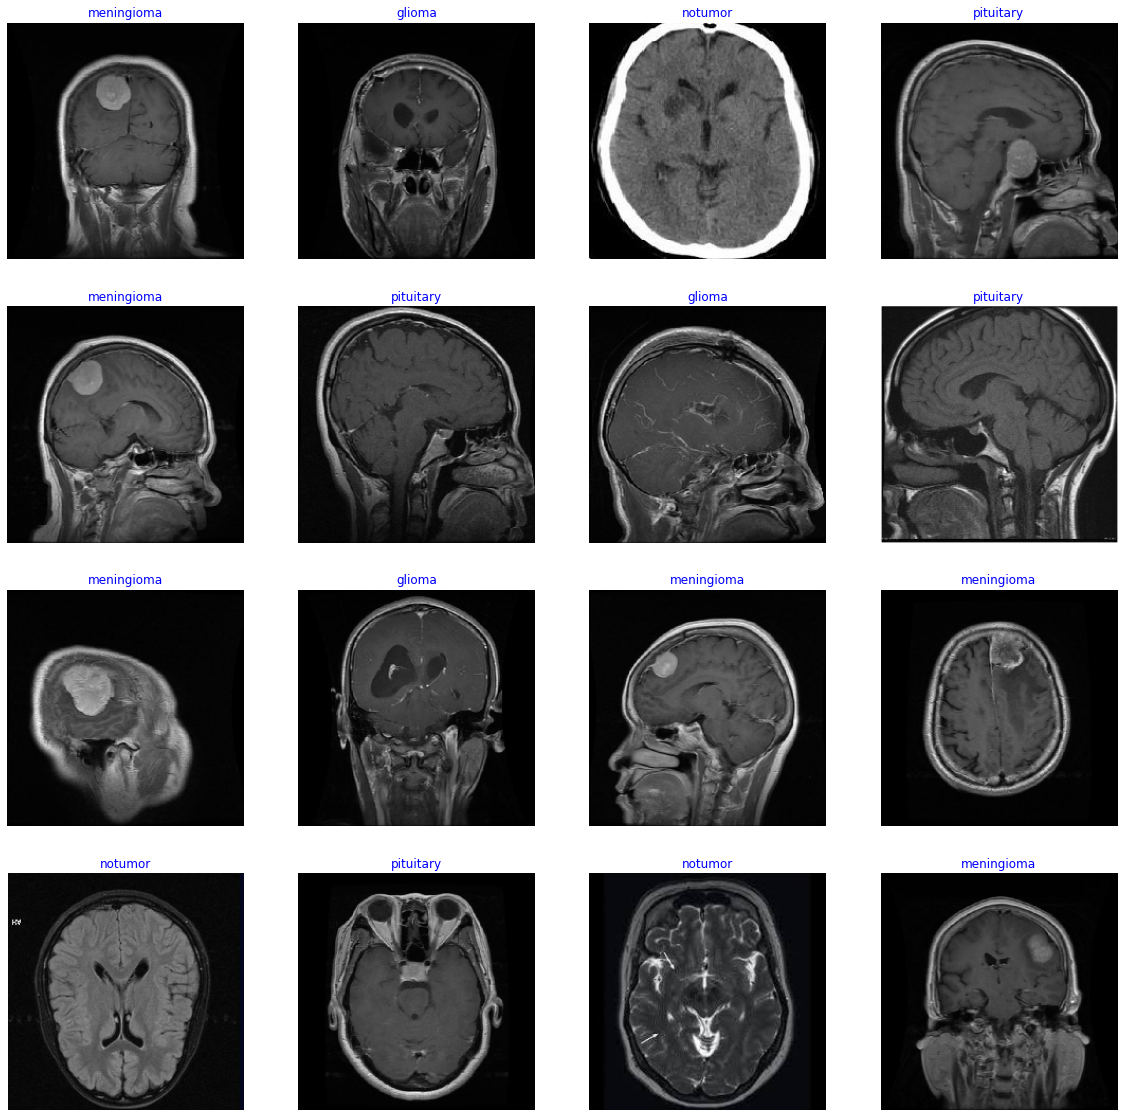

In [6]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show()

## 模型结构

In [7]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = 'relu' ,input_shape=img_shape),
    Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    

    Dense(256, activation='relu',input_dim=30),
    Dense(64,activation = 'relu'),
    Dense(class_count, activation = 'softmax')
])
model.compile(Adamax(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [8]:
epochs = 20

history = model.fit(x=train_gen,epochs= epochs, validation_data=valid_gen,shuffle= False)

Epoch 1/20
357/357 [==============================] - 67s 166ms/step - loss: 1.6951 - accuracy: 0.7043 - val_loss: 0.7464 - val_accuracy: 0.6794
Epoch 2/20
357/357 [==============================] - 59s 165ms/step - loss: 0.3630 - accuracy: 0.8692 - val_loss: 0.4332 - val_accuracy: 0.8321
Epoch 3/20
357/357 [==============================] - 59s 165ms/step - loss: 0.2434 - accuracy: 0.9149 - val_loss: 0.4230 - val_accuracy: 0.8397
Epoch 4/20
357/357 [==============================] - 59s 164ms/step - loss: 0.1659 - accuracy: 0.9433 - val_loss: 0.2194 - val_accuracy: 0.9160
Epoch 5/20
357/357 [==============================] - 59s 164ms/step - loss: 0.1201 - accuracy: 0.9575 - val_loss: 0.2467 - val_accuracy: 0.9206
Epoch 6/20
357/357 [==============================] - 59s 165ms/step - loss: 0.0807 - accuracy: 0.9722 - val_loss: 0.1623 - val_accuracy: 0.9435
Epoch 7/20
357/357 [==============================] - 60s 167ms/step - loss: 0.0662 - accuracy: 0.9779 - val_loss: 0.2134 - val_ac

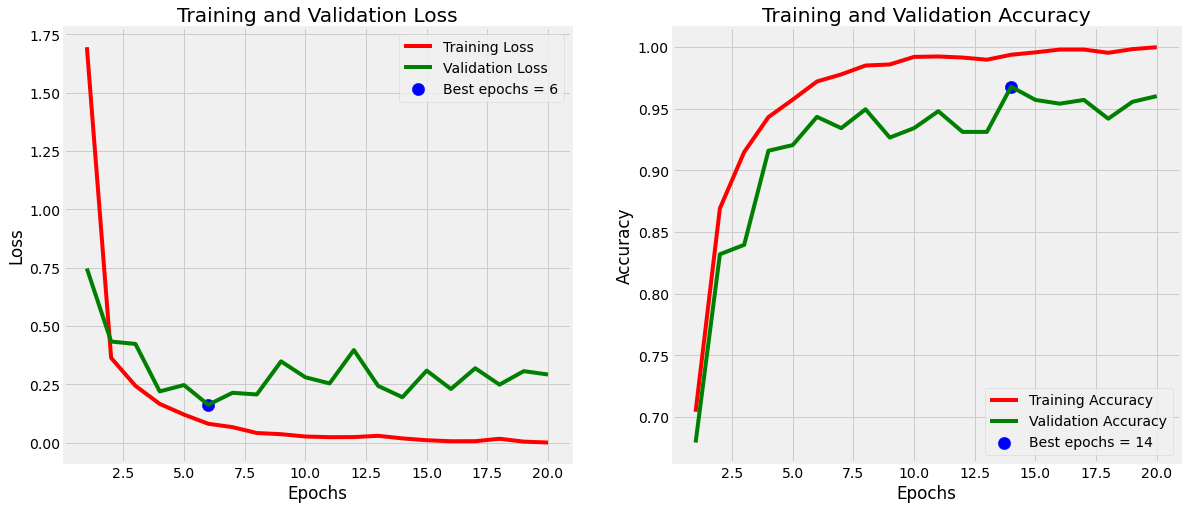

In [9]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()




## 评估模型

In [10]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

41/41 [==============================] - 2s 53ms/step - loss: 0.2321 - accuracy: 0.9619


In [11]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)
y_pred

array([1, 2, 3, 0, 1, 2, 2, 3, 1, 3, 3, 1, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3,
       0, 0, 3, 1, 0, 2, 0, 1, 0, 0, 1, 3, 2, 0, 3, 2, 3, 1, 0, 2, 1, 3,
       2, 2, 0, 1, 1, 3, 0, 2, 2, 2, 0, 2, 1, 3, 0, 1, 2, 3, 1, 2, 2, 3,
       2, 1, 3, 1, 0, 3, 0, 3, 3, 0, 1, 2, 3, 2, 2, 1, 2, 1, 2, 0, 2, 0,
       2, 1, 3, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 0, 3, 2, 3, 1, 2, 2, 1,
       0, 2, 3, 0, 1, 3, 1, 2, 3, 2, 3, 2, 2, 1, 0, 1, 3, 0, 0, 1, 0, 2,
       0, 2, 2, 0, 3, 2, 2, 3, 2, 1, 0, 2, 0, 3, 2, 3, 2, 2, 0, 0, 2, 1,
       1, 0, 2, 1, 1, 0, 1, 0, 2, 0, 2, 2, 3, 3, 0, 0, 0, 0, 3, 0, 0, 1,
       0, 2, 3, 3, 3, 0, 0, 0, 2, 3, 0, 0, 2, 0, 3, 0, 2, 3, 2, 1, 0, 0,
       0, 2, 0, 1, 3, 1, 3, 0, 0, 1, 1, 0, 3, 2, 0, 1, 0, 0, 1, 1, 1, 2,
       0, 2, 1, 1, 3, 1, 0, 3, 0, 3, 3, 2, 3, 1, 3, 1, 2, 0, 1, 2, 3, 2,
       2, 0, 0, 2, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 3, 0, 1, 0, 2, 0, 2, 2,
       2, 3, 0, 1, 3, 3, 0, 1, 1, 0, 3, 1, 2, 1, 3, 3, 2, 2, 2, 1, 2, 3,
       3, 0, 3, 3, 1, 0, 2, 2, 1, 0, 3, 1, 2, 3, 3,

In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm 

array([[153,  11,   0,   0],
       [  7, 140,   0,   3],
       [  2,   0, 191,   0],
       [  0,   2,   0, 147]], dtype=int64)

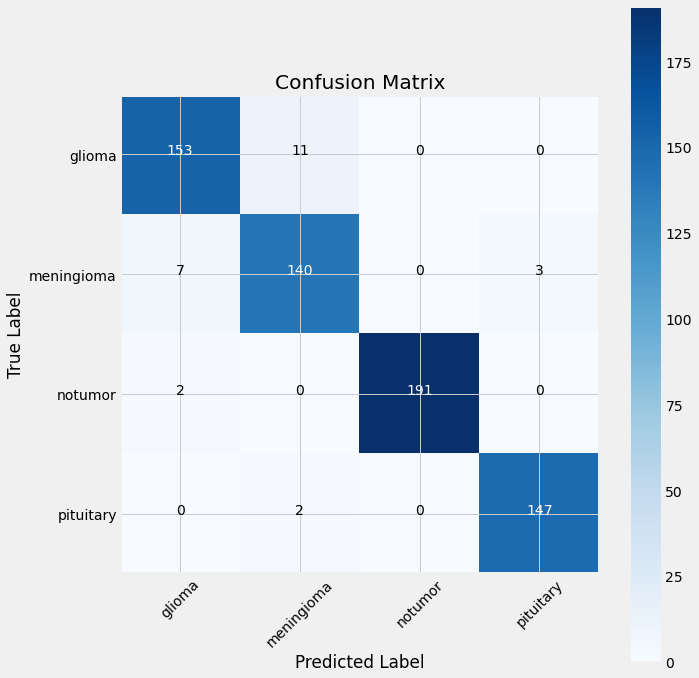

In [13]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [14]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.94      0.93      0.94       164
  meningioma       0.92      0.93      0.92       150
     notumor       1.00      0.99      0.99       193
   pituitary       0.98      0.99      0.98       149

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



## 保存模型

In [15]:
model.save('Brain.h5')

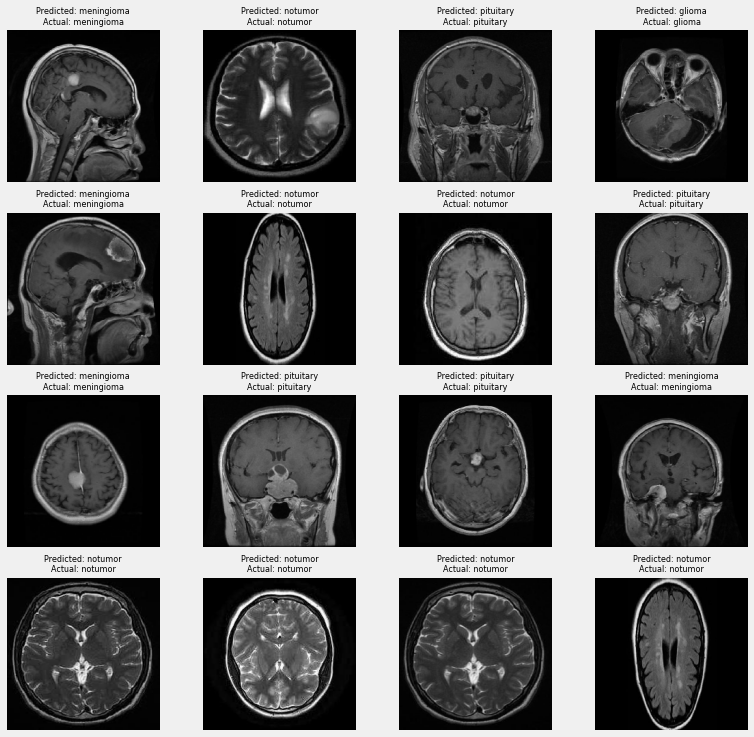

In [16]:
# 定义类别标签
class_labels = classes
# 请根据你的实际情况替换类别标签

predictions = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

# 使用测试生成器进行预测
# predictions = model.predict(test_gen)

# 获取预测结果
# predicted_labels = tf.argmax(predictions, axis=1).numpy()
predicted_labels = np.argmax(preds , axis = 1)

# 获取真实结果
true_labels = test_gen.classes


# 展示预测结果和真实结果
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, (image, true_label, predicted_label) in enumerate(zip(test_gen[0][0], true_labels, predicted_labels)):
    axes[i // 4, i % 4].imshow(image/255)
    axes[i // 4, i % 4].set_title(f'Predicted: {class_labels[predicted_label]}\nActual: {class_labels[true_label]}',fontsize = 8)
    axes[i // 4, i % 4].axis('off')

plt.show()